# HW_1: Grad Boost

### Часть 1. EDA

Проведите EDA, познакомьтесь с признаками, посмотрите зависимости и т.д.

### Часть 2. Preprocessing & Feature Engineering
Хотя цель этого задания - посмотреть на работу алгоритмов, тем не менее пропускать препроцессинг нельзя :)
Так что переведите категориальные переменные в уникальные лейблы при помощи LabelEncoder, попробуйте добавить новые переменные и выкинуть лишние и, наконец, разбейте данные на train-test.

### Часть 3. Какая модель более производительная?
#### 3.1Постройте 4 варианта градиентного бустинга, используя значения гиперпараметров “из коробки”: реализация из sklearn, XGBoost, CatBoost, LightGBM
Проверьте качество на отложенной выборке, кто пока лидирует?
#### 3.2.Теперь проведите настройку гиперпараметров моделей на кросс-валидации, можно настраивать только самые основные гиперпараметры - число итераций бустинга, max_features, subsample и т.д.
Снова проверьте качество уже настроенных моделей. Кто в итоге победил?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score
from sklearn.metrics import get_scorer
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
import os
import graphviz

import xgboost as xgb
from sklearn import metrics
#import pydotplus

from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

# Часть 1. EDA

## План исследования данных
1. Обзор данных:
Загрузите набор данных и просмотрите его структуру.
Определите ключевые столбцы, включая демографические данные клиентов и статус оттока.

2. Описательный анализ:
Получение сводной статистики для числовых столбцов
Визуализируйте распределение оттока и определите тенденции.

3. Категориальный анализ:
Изучите категориальные переменные
Проанализируйте их влияние на уровень оттока.

4. Причины оттока:
Выясните причины оттока.
Поймите основные причины оттока клиентов.

5. Корреляционный анализ

6. Проверка гипотез 

7. Предложения по следующим шагам анализа данных

8. Сводная информация о качестве данных

### Data  - предсказание оттока пользователей

In [2]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col=0)
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## О наборе данных

«Прогнозируйте поведение, чтобы удерживать клиентов. Вы можете анализировать все соответствующие данные о клиентах и разрабатывать целевые программы удержания клиентов». 

Набор данных включает в себя информацию о:

- Клиенты, ушедшие в течение последнего месяца – столбец называется «Churn».\ 
- Услуги, на которые подписался каждый клиент: телефон, несколько линий, Интернет, онлайн-безопасность, онлайн-резервное копирование, защита устройства, техническая поддержка, а также потоковое ТВ и фильмы. \
- Информация об учетной записи клиента: как долго он является клиентом, договор, способ оплаты, безбумажные счета, ежемесячные платежи и общая сумма платежей. \
- Демографическая информация о клиентах – пол, возрастной диапазон, наличие у них партнеров и иждивенцев.

Описание признаков: 

**customerID**: Идентификатор клиента \
**gender**: является ли клиент мужчиной или женщиной. \
**SeniorCitizen**: является ли клиент пожилым человеком или нет (1, 0). \
**Partner**: есть ли у клиента партнер или нет (да, нет) \
**Dependents**: есть ли у клиента иждивенцы или нет (да, нет) \
**tenure**: количество месяцев, в течение которых клиент оставался в компании. \
**PhoneService**: есть ли у клиента телефонная связь или нет (да, нет) \
**MultipleLines**: имеет ли клиент несколько линий или нет (да, нет, нет телефонной связи). \
**InternetService**: Интернет-провайдер клиента (DSL, оптоволокно, нет) \ 
**OnlineSecurity**: есть ли у клиента онлайн-безопасность или нет (да, нет, нет интернет-услуги) \
**OnlineBackup**: есть ли у клиента онлайн-резервное копирование или нет (да, нет, нет интернет-услуги) \
**DeviceProtection**: есть ли у клиента защита устройства или нет (да, нет, нет интернет-услуги) \
**TechSupport**: есть ли у клиента техническая поддержка или нет (да, нет, нет интернет-услуги) \
**StreamingTV**: есть ли у клиента потоковое телевидение или нет (да, нет, нет интернет-услуги) \
**StreamingMovies**: есть ли у клиента потоковая передача фильмов или нет (да, нет, нет интернет-услуги) \
**Contract**: Срок контракта с клиентом (ежемесячно, один год, два года). \
**PaperlessBilling**: имеет ли клиент безбумажное выставление счетов или нет (да, нет) \
**PaymentMethod**: способ оплаты клиента (электронный чек, чек по почте, банковский перевод (автоматически), кредитная карта (автоматически)) \
**MonthlyCharges**: сумма, взимаемая с клиента ежемесячно. \
**TotalCharges**: общая сумма, списанная с клиента. \
**Churn**: ушел ли клиент или нет (да или нет). \

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

TotalCharges - общая сумма, списанная с клиента записана как категориальный признак, хотя является float

In [4]:
total_charge = data["TotalCharges"]
missing = total_charge[~total_charge.str.replace(".", "").str.isdigit()]
print("Number of missing total charge: ", len(missing))
missing.head()

Number of missing total charge:  11


customerID
4472-LVYGI     
3115-CZMZD     
5709-LVOEQ     
4367-NUYAO     
1371-DWPAZ     
Name: TotalCharges, dtype: object

В столбце "TotalCharges" общей суммы расходов есть пропущенные значения.

In [5]:
# Преобразование категориального столбца TotalCharges в численный вид
data["TotalCharges"] = data["TotalCharges"].apply(pd.to_numeric, errors="coerce")

###  Проверка на пропуски данных

In [6]:
# Вычисляем долю пропущенных значений для каждого столбца в DataFrame
np.round(data.isna().sum()[data.isna().sum()>0] / data.shape[0], 2)

TotalCharges    0.0
dtype: float64

In [7]:
features_with_na=data.isna().sum()[data.isna().sum()>0] / data.shape[0]
list_to_drop=features_with_na[features_with_na>0.3].index.tolist()
list_to_drop

[]

In [8]:
data.dropna(inplace=True)

In [9]:
data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## 1.2. Базовые статистики датасета

### Распределение числовых признаков

In [10]:
data.describe().round(2)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.00,7032.00,7032.00,7032.00
mean,0.16,32.42,64.80,2283.30
std,0.37,24.55,30.09,2266.77
min,0.00,1.00,18.25,18.80
25%,0.00,9.00,35.59,401.45
50%,0.00,29.00,70.35,1397.48
75%,0.00,55.00,89.86,3794.74
max,1.00,72.00,118.75,8684.80


### Целевая переменная: ушел клиент или нет

In [11]:
# data["Churn"] = np.where(data["Churn"] == "Y", 1, 0)

### Корреляция между целевой переменной  и признаками

In [12]:
data[['Churn','SeniorCitizen','tenure','MonthlyCharges']].corr().round(2)

,SeniorCitizen,tenure,MonthlyCharges
SeniorCitizen,1.00,0.02,0.22
tenure,0.02,1.00,0.25
MonthlyCharges,0.22,0.25,1.00


In [13]:
# data.corr().sort_values('Churn', ascending=False).round(2)

In [14]:
# Определим заголовки в категориальных переменных
for col in data.columns[0:20]:
    print(col, np.unique(data[col]))

gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['No' 'Yes']
Dependents ['No' 'Yes']
tenure [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
PhoneService ['No' 'Yes']
MultipleLines ['No' 'No phone service' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'No internet service' 'Yes']
OnlineBackup ['No' 'No internet service' 'Yes']
DeviceProtection ['No' 'No internet service' 'Yes']
TechSupport ['No' 'No internet service' 'Yes']
StreamingTV ['No' 'No internet service' 'Yes']
StreamingMovies ['No' 'No internet service' 'Yes']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['No' 'Yes']
PaymentMethod ['Bank transfer (automatic)' 'Credit card (automatic)' 'Electronic check'
 'Mailed check']
MonthlyCharges [ 18.25  18.4   18.55 ... 118.6  118.65 118.75]
TotalCharges [  18.8    1

## 2.2. Visualization - Выявление взаимосвязи

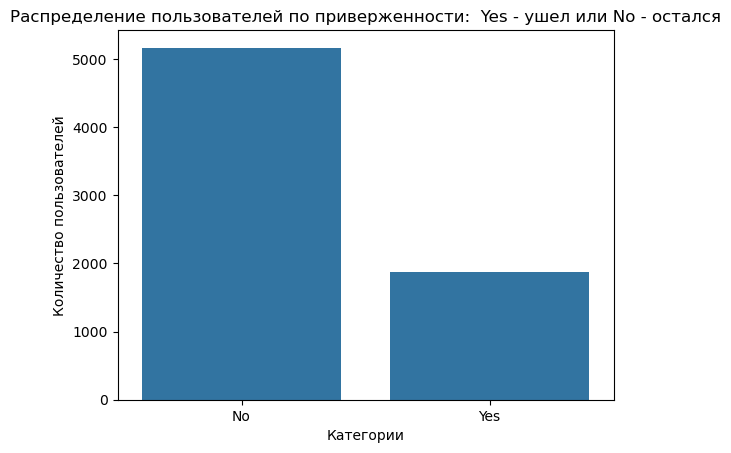

In [15]:
score_counts = data.Churn.value_counts()
sns.barplot(x = score_counts.index, y = score_counts.values)
plt.title('Распределение пользователей по приверженности:  Yes - ушел или No - остался')
plt.ylabel('Количество пользователей')
plt.xlabel('Категории');

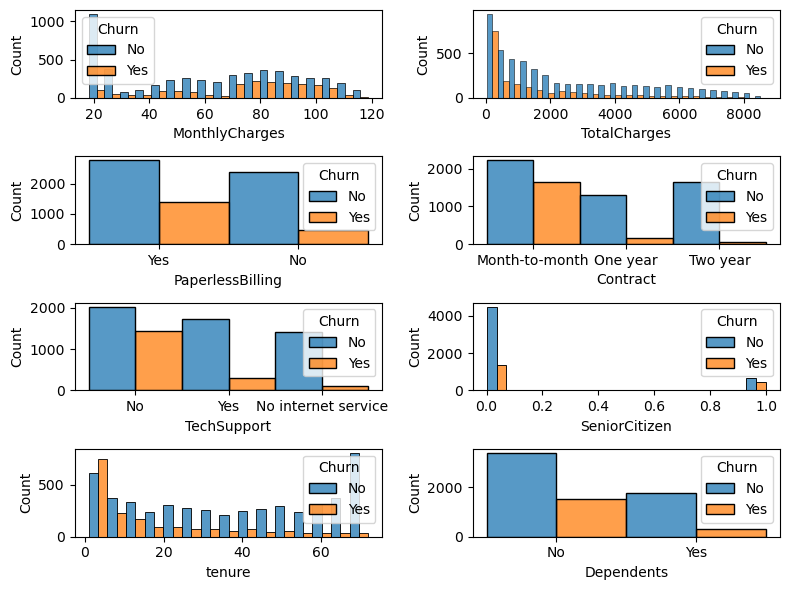

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(8, 6))

sns.histplot(data=data, x="MonthlyCharges", hue="Churn", multiple="dodge", ax=axes[0, 0])

sns.histplot(data=data, x="TotalCharges", hue="Churn", multiple="dodge", ax=axes[0, 1])

sns.histplot(data=data, x="PaperlessBilling", hue="Churn", multiple="dodge", ax=axes[1, 0])

sns.histplot(data=data, x="Contract", hue="Churn", multiple="dodge", ax=axes[1, 1])

sns.histplot(data=data, x="TechSupport", hue="Churn", multiple="dodge", ax=axes[2, 0])

sns.histplot(data=data, x="SeniorCitizen", hue="Churn", multiple="dodge", ax=axes[2, 1])

sns.histplot(data=data, x="tenure", hue="Churn", multiple="dodge", ax=axes[3, 0])

sns.histplot(data=data, x="Dependents", hue="Churn", multiple="dodge", ax=axes[3, 1])

plt.tight_layout()
plt.show()

Из графиков видно, что наибольшее влияние на Churn (ушел) оказывают:
- общий счет (чем он больше, тем меньше пользователей)
- количество месяцев, в течение которых клиент оставался в компании 
- тип Contract
- месячная оплата (очень маленькая помесячная оплата удерживает, но я подозреваю, что это была акция "месяц бесплатно")
- No internet servises
- SeniorCitizen (является ли клиент пожилым человеком - 1 или нет - 0). Пожилые уходят.
- имеет ли клиент безбумажное выставление счетов или нет 

Менее сильно влияет наличие иждивенцев, но наличие иждивенцев ведет к уходу.

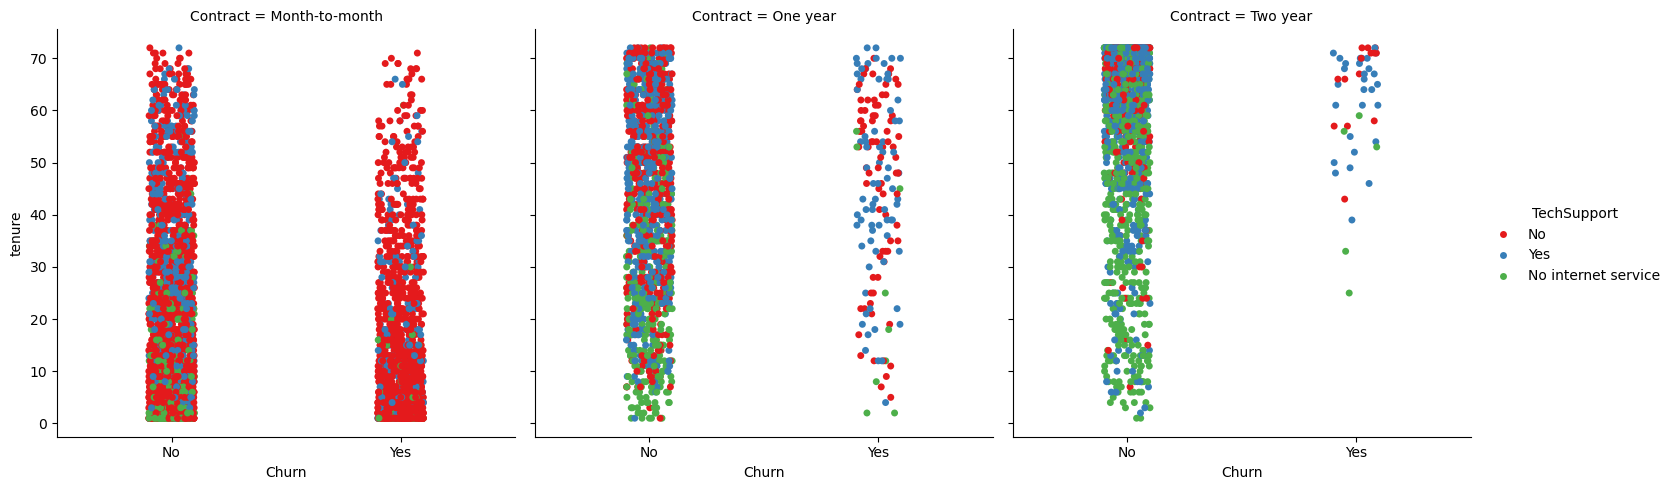

In [17]:
sns.catplot(x = 'Churn', y = 'tenure', hue = 'TechSupport', col = 'Contract', data = data, kind = 'strip', palette='Set1')

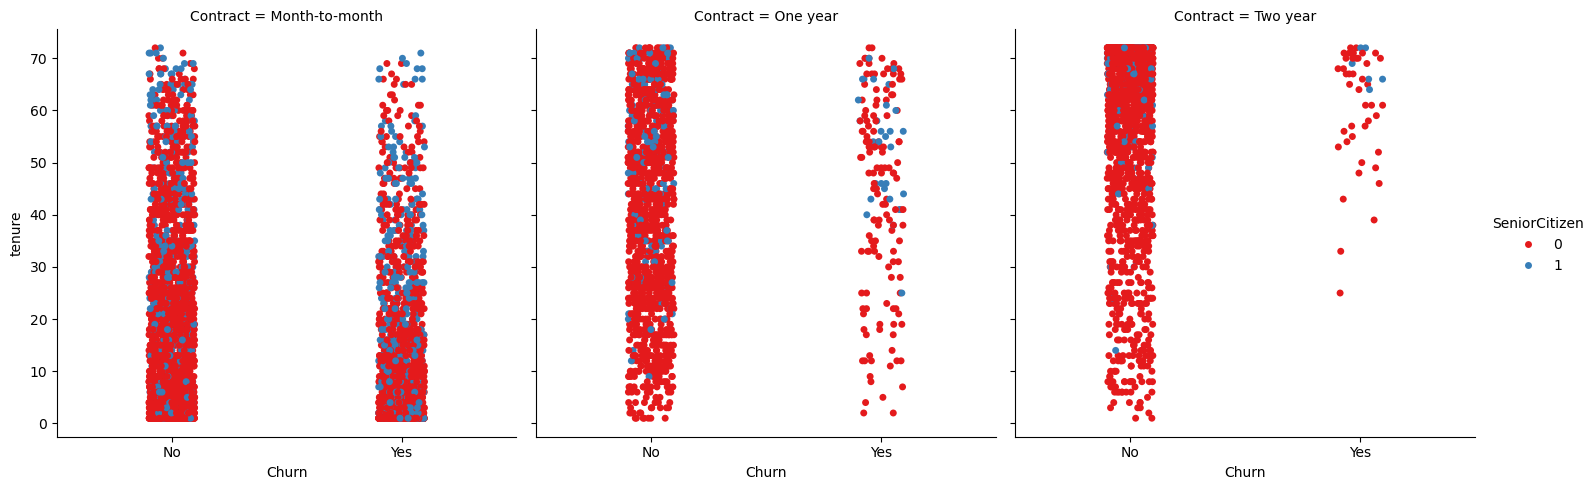

In [18]:
sns.catplot(x = 'Churn', y = 'tenure', hue = 'SeniorCitizen', col = 'Contract', data = data, kind = 'strip', palette='Set1')

- Прослеживается явная зависимость Churn от типа (длины) контракта: при одно- и двухлетних контрактах пользователи практически не уходят (более лояльны).
- а также зависимость Contract от технической поддержки: техническая поддержка удерживает людей с однолетними и двухлетними контрактами. Люди без интеренет-сервиса предпочитают двухлетние контракты.

# 2.Препроцессинг

## Label Encoder
На вход LabelEncoder принимает только одномерные массивы (например, Series)

In [19]:
# Cоздаем список `columns_to_encode`, содержащий имена столбцов, которые нужно закодировать. 
# Затем используем цикл `for`, чтобы применить LabelEncoder к каждому столбцу в списке. 
# Теперь все выбранные столбцы будут закодированы с помощью LabelEncoder

from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['gender','Partner','Dependents','PhoneService','PaperlessBilling','Churn', 'MultipleLines', 
                     'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                     'StreamingTV', 'StreamingMovies','Contract']
labelencoder = LabelEncoder()

data_le = data.copy()
for column in columns_to_encode:
    data_le[column] = labelencoder.fit_transform(data_le[column])
data_le

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,Electronic check,29.85,29.85,0
5575-GNVDE,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,Mailed check,56.95,1889.50,0
3668-QPYBK,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,Mailed check,53.85,108.15,1
7795-CFOCW,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,Bank transfer (automatic),42.30,1840.75,0
9237-HQITU,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,1,0,1,1,24,1,2,0,2,0,2,2,2,2,1,1,Mailed check,84.80,1990.50,0
2234-XADUH,0,0,1,1,72,1,2,1,0,2,2,0,2,2,1,1,Credit card (automatic),103.20,7362.90,0
4801-JZAZL,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,Electronic check,29.60,346.45,0


### Построение heatmap

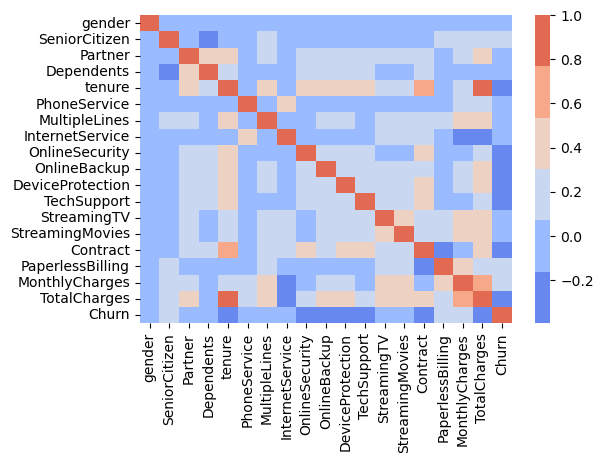

In [20]:
plt.subplots(figsize=(6,4))
sns.heatmap(data_le.corr(), cmap=sns.color_palette("coolwarm"))
plt.show()

In [21]:
k = 7
corrmat = data_le.corr()
cols = corrmat.nlargest(k, 'Churn')['Churn'].index.tolist()
cols

['Churn',
 'MonthlyCharges',
 'PaperlessBilling',
 'SeniorCitizen',
 'MultipleLines',
 'PhoneService',
 'gender']

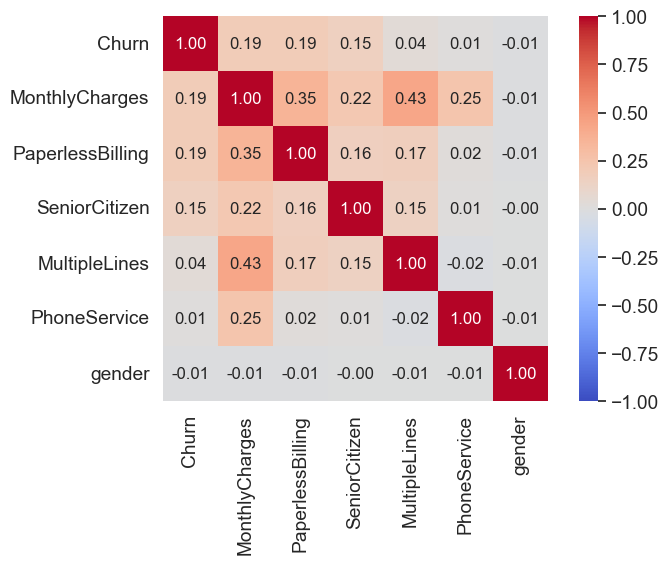

In [22]:
cm = np.corrcoef(data_le[cols].values.T)
plt.figure(figsize=(8,5))
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},\
                yticklabels=cols, xticklabels=cols, vmin=-1, center=0,\
                    cmap=sns.color_palette('coolwarm',1000))
plt.show()

ИТОГИ: Наиболее сильную корреляцию с уходом показали параметры: Месячная оплата, Имеет ли клиент безбумажное выставление счетов или нет, и является ли клиент пожилым человеком или нет. Это отличается от предварительной аналитики.

In [23]:
data_le['Churn'].value_counts(normalize=True)

0    0.734215
1    0.265785
Name: Churn, dtype: float64

In [24]:
data_l= data_le.drop(columns='PaymentMethod')

# Выбор метрики

В задаче по определению оттока абонентов, ошибкой первого рода будет принятие лояльного абонента за уходящего, так как наша нулевая гипотеза состоит в том, что никто из абонентов не уходит, а мы эту гипотезу отвергаем. 
Соответственно, ошибкой второго рода будет являться "пропуск" уходящего абонента и ошибочное принятие нулевой гипотезы.

Precision и recall не зависят, в отличие от accuracy, от соотношения классов и потому применимы в условиях несбалансированных выборок. В реальной практике стоит задача найти оптимальный (для заказчика) баланс между этими двумя метриками. 

Очевидно, что мы не можем находить всех уходящих клиентов и только их. Но, определив стратегию и ресурс для удержания клиентов, мы можем подобрать нужные пороги по precision и recall. Например, можно сосредоточиться на удержании только высокодоходных клиентов или тех, кто уйдет с большей вероятностью, так как мы ограничены в ресурсах.

Обычно при оптимизации гиперпараметров алгоритма (например, в случае перебора по сетке GridSearchCV ) используется одна метрика, улучшение которой мы и ожидаем увидеть на тестовой выборке. Поскольку наблюдается дисбаланс классов (2,7:1) в данной задаче было бы логично использовать метрику F1.

# Модель 1: XGBoost

In [82]:
import xgboost as xgb

In [83]:
from xgboost import XGBClassifier
X = data_l.drop(['Churn'], axis=1)
y = data_l['Churn']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,  stratify=y)

In [84]:
clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [85]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1033
           1       0.59      0.50      0.54       374

    accuracy                           0.77      1407
   macro avg       0.71      0.69      0.70      1407
weighted avg       0.76      0.77      0.77      1407



In [86]:
# Отчет в виде словаря.
report = classification_report(y_test, clf.predict(X_test), output_dict=True)
xgb_before_f1 = report['weighted avg']['f1-score']
print("xgb_before_f1_score:", xgb_before_f1)

xgb_before_f1_score: 0.7678244416824375


In [74]:
xgb_before_precision = report['weighted avg']['precision']
print("xgb_before_precision:", xgb_before_precision)

xgb_before_precision: 0.7644257137357672


In [75]:
print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк в y_train по классам: [4130 1495]
Количество строк в y_test по классам: [1033  374]


Есть дисбаланс по классам, но я бы не назвала его критичным

In [76]:
# Вывод важности признаков
pd.DataFrame(clf.feature_importances_, index = list(X_train), 
             columns = ['feature importance']).sort_values('feature importance', ascending = False)[:7]

,feature importance
Contract,0.412401
InternetService,0.201584
OnlineSecurity,0.082777
TechSupport,0.046549
tenure,0.026337
OnlineBackup,0.021319
PaperlessBilling,0.020695


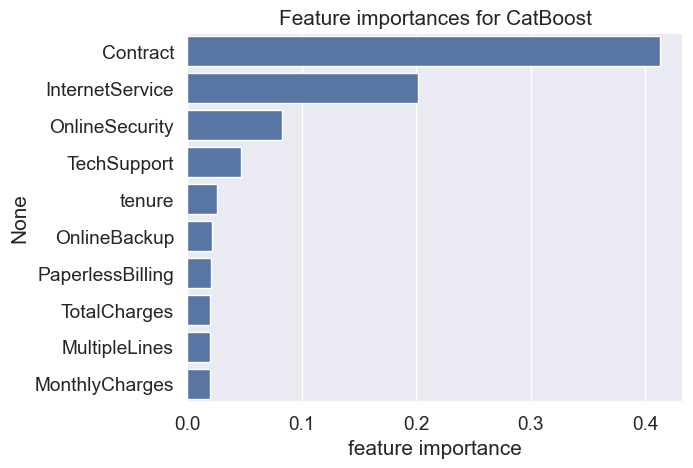

In [77]:
importance_df = pd.DataFrame(clf.feature_importances_, index = list(X_train), 
             columns = ['feature importance']).sort_values('feature importance', ascending = False)[:10]

plt.title('Feature importances for CatBoost')
sns.barplot(x='feature importance', y=importance_df.index, data=importance_df)
plt.show()

### Grid Search СV

In [47]:
param_dist = {"max_depth": [5, 10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.1, 0.05, 0.01],}

In [48]:
model = GridSearchCV(model, param_grid=param_dist, scoring='f1', cv=5, verbose=10, n_jobs=-1)
                        
# Run Grid Search optimization
model.fit(X_train, y_train)
pred = model.predict(X_test)
model.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 200}

In [53]:
# Обновим модель:
model_grid = XGBClassifier(learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=200, n_jobs=-1)
model_grid.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [54]:
y_pred_grid = model_grid.predict(X_test)
print(classification_report(y_pred_grid, y_test))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1088
           1       0.53      0.62      0.57       319

    accuracy                           0.79      1407
   macro avg       0.71      0.73      0.72      1407
weighted avg       0.80      0.79      0.79      1407



In [78]:
# Отчет в виде словаря.
report = classification_report(y_test, model_grid.predict(X_test), output_dict=True)
xgb_after_f1 = report['weighted avg']['f1-score']
print("xgboost_after_f1_score:", xgb_after_f1)

xgboost_after_f1_score: 0.7832729663462844


In [79]:
xgb_after_precision = report['weighted avg']['precision']
print("xgb_after_precision:", xgb_after_precision)

xgb_after_precision: 0.780408663722823


# Модель 2: Catboost

In [95]:
from catboost import CatBoostClassifier

X = data_l.drop(['Churn'], axis=1)
y = data_l['Churn']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,  stratify=y)

In [96]:
clf = CatBoostClassifier(iterations=50, logging_level='Silent')
clf.fit(X_train, y_train)

In [97]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.52      0.58       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.79      0.79      1407



In [98]:
# Отчет в виде словаря.
report = classification_report(y_test, clf.predict(X_test), output_dict=True)
catb_before_f1 = report['weighted avg']['f1-score']
print("Catboost_before_f1_score:", catb_before_f1)

Catboost_before_f1_score: 0.7877201983545301


In [99]:
catb_before_precision = report['weighted avg']['precision']
print("catb_before_precision:", catb_before_precision)

catb_before_precision: 0.7850867537181894


In [100]:
print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк в y_train по классам: [4130 1495]
Количество строк в y_test по классам: [1033  374]


In [101]:
# Вывод важности признаков
pd.DataFrame(clf.feature_importances_, index = list(X_train), 
             columns = ['feature importance']).sort_values('feature importance', ascending = False)[:8]

,feature importance
Contract,15.972360
TotalCharges,14.355467
tenure,11.955475
MonthlyCharges,10.698714
OnlineSecurity,6.227958
InternetService,6.191570
TechSupport,5.523175
PaperlessBilling,4.202170


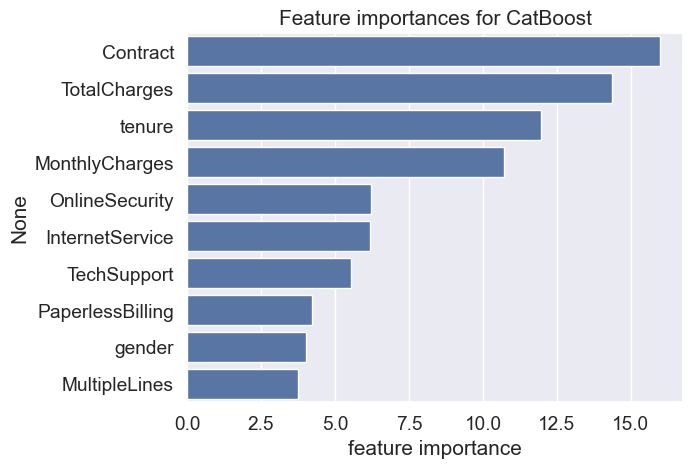

In [102]:
importance_df = pd.DataFrame(clf.feature_importances_, index = list(X_train), 
             columns = ['feature importance']).sort_values('feature importance', ascending = False)[:10]

plt.title('Feature importances for CatBoost')
sns.barplot(x='feature importance', y=importance_df.index, data=importance_df)
plt.show()

### Grid Search CV

In [103]:
# Оценка сетки гиперпараметров классификатора
param_grid = {'depth'         : [3,4,5,6,7,8,],
              'learning_rate' : [0.01, 0.04, 0.1, 0.2],
              'iterations'    : [10,20,30]
                 }

In [104]:
model = CatBoostClassifier()
# to be standart sklearn's scorer        

# Define GridSearch parameters
clf = GridSearchCV(model, param_grid, scoring='f1', cv=5, n_jobs=-1)
                        
# Run Grid Search optimization
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
clf.best_params_

0:	learn: 0.6184192	total: 13.9ms	remaining: 403ms
1:	learn: 0.5688812	total: 19.1ms	remaining: 267ms
2:	learn: 0.5310175	total: 22.9ms	remaining: 206ms
3:	learn: 0.5013884	total: 27.9ms	remaining: 181ms
4:	learn: 0.4807637	total: 32.8ms	remaining: 164ms
5:	learn: 0.4665622	total: 37.7ms	remaining: 151ms
6:	learn: 0.4534883	total: 42.7ms	remaining: 140ms
7:	learn: 0.4424138	total: 47.6ms	remaining: 131ms
8:	learn: 0.4336876	total: 52.5ms	remaining: 123ms
9:	learn: 0.4262886	total: 57.6ms	remaining: 115ms
10:	learn: 0.4205816	total: 62.6ms	remaining: 108ms
11:	learn: 0.4159077	total: 67.4ms	remaining: 101ms
12:	learn: 0.4125318	total: 70ms	remaining: 91.6ms
13:	learn: 0.4090493	total: 75ms	remaining: 85.8ms
14:	learn: 0.4054663	total: 79.9ms	remaining: 79.9ms
15:	learn: 0.4040964	total: 82.3ms	remaining: 72ms
16:	learn: 0.4011735	total: 87.3ms	remaining: 66.8ms
17:	learn: 0.3986824	total: 92.2ms	remaining: 61.5ms
18:	learn: 0.3961652	total: 97.1ms	remaining: 56.2ms
19:	learn: 0.3942766	

{'depth': 7, 'iterations': 30, 'learning_rate': 0.2}

In [105]:
# Обновим модель:
model_grid = CatBoostClassifier(depth=7, iterations=30, learning_rate = 0.2)
model_grid.fit(X_train, y_train)

0:	learn: 0.6184192	total: 4.65ms	remaining: 135ms
1:	learn: 0.5688812	total: 11.4ms	remaining: 160ms
2:	learn: 0.5310175	total: 16.5ms	remaining: 148ms
3:	learn: 0.5013884	total: 21.6ms	remaining: 141ms
4:	learn: 0.4807637	total: 26.8ms	remaining: 134ms
5:	learn: 0.4665622	total: 32.2ms	remaining: 129ms
6:	learn: 0.4534883	total: 37.5ms	remaining: 123ms
7:	learn: 0.4424138	total: 42.3ms	remaining: 116ms
8:	learn: 0.4336876	total: 47.8ms	remaining: 112ms
9:	learn: 0.4262886	total: 53.2ms	remaining: 106ms
10:	learn: 0.4205816	total: 59ms	remaining: 102ms
11:	learn: 0.4159077	total: 64.3ms	remaining: 96.5ms
12:	learn: 0.4125318	total: 67.3ms	remaining: 88ms
13:	learn: 0.4090493	total: 72.8ms	remaining: 83.2ms
14:	learn: 0.4054663	total: 78.3ms	remaining: 78.3ms
15:	learn: 0.4040964	total: 81.3ms	remaining: 71.1ms
16:	learn: 0.4011735	total: 86.6ms	remaining: 66.2ms
17:	learn: 0.3986824	total: 91.7ms	remaining: 61.2ms
18:	learn: 0.3961652	total: 97.2ms	remaining: 56.3ms
19:	learn: 0.39427

In [106]:
y_pred_grid = model_grid.predict(X_test)
print(classification_report(y_pred_grid, y_test))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1113
           1       0.49      0.63      0.55       294

    accuracy                           0.79      1407
   macro avg       0.69      0.73      0.71      1407
weighted avg       0.81      0.79      0.80      1407



In [107]:
# Отчет в виде словаря.
report = classification_report(y_test, clf.predict(X_test), output_dict=True)
catb_after_f1 = report['weighted avg']['f1-score']
print("Catboost_after_f1_score:", catb_after_f1)

Catboost_after_f1_score: 0.7779870126787205


In [108]:
catb_after_precision = report['weighted avg']['precision']
print("catb_after_precision:", catb_after_precision)

catb_after_precision: 0.7752130850596934


Выводы: модель CatBoost показала среднюю предсказательную силу (нижний порог 0,7):  метрика F1 до и после GridSearch = 0.778. Метрика Precision показала 0.781.
То, что оптимизация гиперпараметров не увеличила точность метрики вполне ожидаемо, так как модель CatBoost дает хорошую точноть
на этапе тестирования, но гиперпараметры ее как правило не улучшают. 

Вывод: после GridSearch метрика F1 осталась такой же, оптимизации не произошло.

# Модель 3: LightGBM

In [109]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.datasets import make_classification
   
# X = data_l.drop(columns=drop_columns)
X = data_l.drop(['Churn'], axis=1)
y = data_l['Churn']                

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

In [110]:
clf = LGBMClassifier(n_estimators=300)
clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1308, number of negative: 3614
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 4922, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,265746 -> initscore=-1,016316
[LightGBM] [Info] Start training from score -1,016316


LGBMClassifier(n_estimators=300)

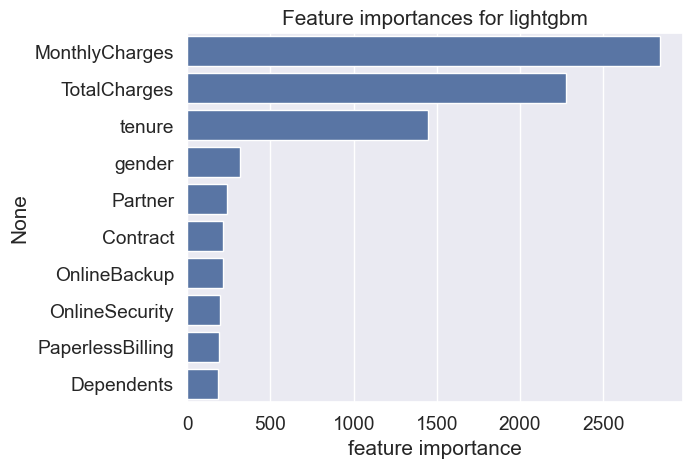

In [111]:
importance_df = pd.DataFrame(clf.feature_importances_, index = list(X_train), 
             columns = ['feature importance']).sort_values('feature importance', ascending = False)[:10]

plt.title('Feature importances for lightgbm')
sns.barplot(x='feature importance', y=importance_df.index, data=importance_df)
plt.show()

In [112]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1549
           1       0.59      0.53      0.56       561

    accuracy                           0.78      2110
   macro avg       0.71      0.70      0.71      2110
weighted avg       0.77      0.78      0.77      2110



In [113]:
# Отчет в виде словаря.
report = classification_report(y_test, clf.predict(X_test), output_dict=True)
lgbm_before_f1 = report['weighted avg']['f1-score']
print("lgbm_before_f1_score:", lgbm_before_f1)

lgbm_before_f1_score: 0.7741918204409444


In [114]:
lgbm_before_precision = report['weighted avg']['precision']
print("lgbm_before_precision:", lgbm_before_precision)

lgbm_before_precision: 0.7714948106903543


### Grid Search CV

In [115]:
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 63],
    'n_estimators': [50]
}

In [116]:
# Initialize the LightGBM model
model = lgb.LGBMClassifier(boosting_type='gbdt',    
                           metric='f1', device='gpu')

#fit_params = {'categorical_feature':indexes_of_categories}
clf = GridSearchCV(model, param_grid, cv=5,n_jobs=-1 )
clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1308, number of negative: 3614
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 4922, number of used features: 18
[LightGBM] [Info] Using GPU Device: Intel(R) HD Graphics 4000, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 15 dense feature groups (0,08 MB) transferred to GPU in 0,001614 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,265746 -> initscore=-1,016316
[LightGBM] [Info] Start training from score -1,016316


GridSearchCV(cv=5, estimator=LGBMClassifier(device='gpu', metric='f1'),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 5, 7], 'n_estimators': [50],
                         'num_leaves': [15, 31, 63]})

In [117]:
print(clf.best_params_, clf.best_score_)

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'num_leaves': 15} 0.806583096034006


In [118]:
# Обновим модель
model_grid = lgb.LGBMClassifier(earning_rate=0.1,
                                    max_depth=7,
                                    num_leaves=15,
                                    n_estimators=50)
model_grid.fit(X_train, y_train)
y_pred_grid = model_grid.predict(X_test)

[LightGBM] [Warning] Unknown parameter: earning_rate
[LightGBM] [Warning] Unknown parameter: earning_rate
[LightGBM] [Info] Number of positive: 1308, number of negative: 3614
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 4922, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,265746 -> initscore=-1,016316
[LightGBM] [Info] Start training from score -1,016316
[LightGBM] [Warning] Unknown parameter: earning_rate


In [119]:
print(classification_report(y_pred_grid, y_test))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1661
           1       0.51      0.64      0.57       449

    accuracy                           0.79      2110
   macro avg       0.70      0.74      0.71      2110
weighted avg       0.81      0.79      0.80      2110



In [120]:
# Отчет в виде словаря.
report = classification_report(y_test, clf.predict(X_test), output_dict=True)
lgbm_after_f1 = report['weighted avg']['f1-score']
print("lgbm_after_f1_score:", lgbm_after_f1)

lgbm_after_f1_score: 0.7845288971471448


In [121]:
lgbm_after_precision = report['weighted avg']['precision']
print("lgbm_after_precision:", lgbm_after_precision)

lgbm_after_precision: 0.781935451941196


Выводы: модель LightGBM  показала среднюю предсказательную силу (нижний порог 0,7):  метрика F1 до оптимизации была равна 0.774, после GridSearch = 0.785. Если бы она была больше 0,95, то это было бы переобучение. Метрика precision до равна 0.771 , после оптимизации 0.781   

## Сравнение результатов

### Сравнение производительности моделей до оптимизации параметров

#### Для F1

Text(0.5, 1.0, 'График F1-score моделей до настройки гиперпараметров')

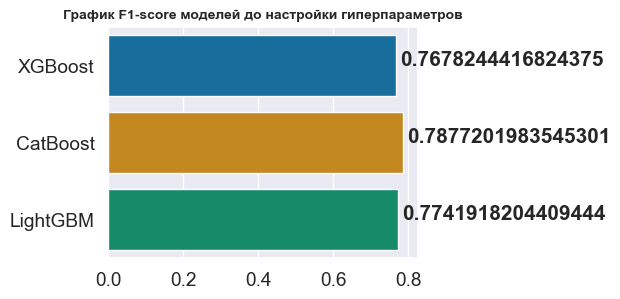

In [122]:
plt.figure(figsize= (4,3))
ac = [xgb_before_f1, catb_before_f1, lgbm_before_f1]
name = ['XGBoost', 'CatBoost', 'LightGBM']
for i in range(len(ac)):
    plt.text(x=ac[i]+0.01, y=i, s=str(ac[i]), fontweight='bold')
sns.barplot(x = ac,y = name,palette='colorblind')
plt.title("График F1-score моделей до настройки гиперпараметров", fontsize=10, fontweight="bold")

#### Для Precision

Text(0.5, 1.0, 'График Precision моделей до настройки гиперпараметров')

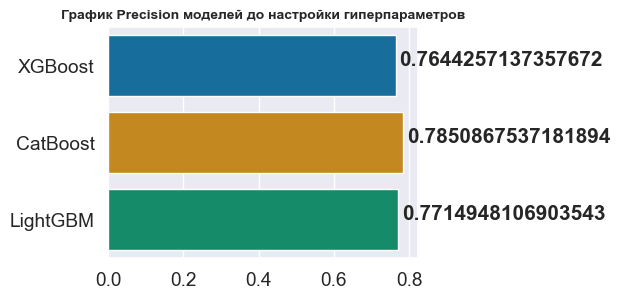

In [123]:
plt.figure(figsize= (4,3))
ac = [xgb_before_precision, catb_before_precision, lgbm_before_precision]
name = ['XGBoost', 'CatBoost', 'LightGBM']
for i in range(len(ac)):
    plt.text(x=ac[i]+0.01, y=i, s=str(ac[i]), fontweight='bold')
sns.barplot(x = ac,y = name,palette='colorblind')
plt.title("График Precision моделей до настройки гиперпараметров", fontsize=10, fontweight="bold")

### Сравнение производительности моделей после оптимизации параметров

#### Для F1

Text(0.5, 1.0, 'График F1-score моделей после настройки гиперпараметров')

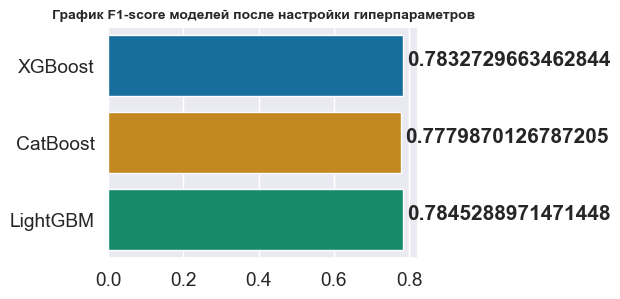

In [124]:
plt.figure(figsize= (4,3))
ac = [xgb_after_f1, catb_after_f1, lgbm_after_f1]
name = ['XGBoost', 'CatBoost', 'LightGBM']
for i in range(len(ac)):
    plt.text(x=ac[i]+0.01, y=i, s=str(ac[i]), fontweight='bold')
sns.barplot(x = ac,y = name,palette='colorblind')
plt.title("График F1-score моделей после настройки гиперпараметров", fontsize=10, fontweight="bold")

#### Для Precision

Text(0.5, 1.0, 'График Precision моделей до настройки гиперпараметров')

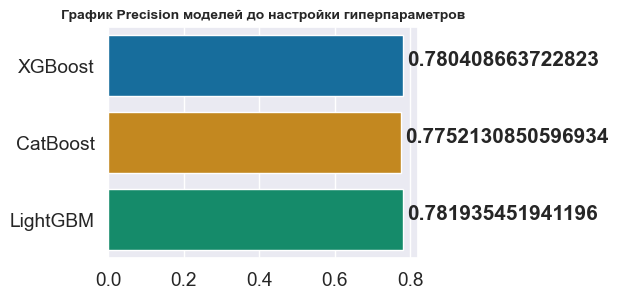

In [125]:
plt.figure(figsize= (4,3))
ac = [xgb_after_precision, catb_after_precision, lgbm_after_precision]
name = ['XGBoost', 'CatBoost', 'LightGBM']
for i in range(len(ac)):
    plt.text(x=ac[i]+0.01, y=i, s=str(ac[i]), fontweight='bold')
sns.barplot(x = ac,y = name,palette='colorblind')
plt.title("График Precision моделей до настройки гиперпараметров", fontsize=10, fontweight="bold")

# Выводы

1. Анализ данных heatmap и полученный на этапе EDA (до предпроцессинга) достаточно сильно отличается. 

На этапе EDA было установлено, что на уход пользователя в наибольшей степени влияют следующие факторы:

- общий счет (чем он больше, тем меньше пользователей)
- количество месяцев, в течение которых клиент оставался в компании 
- тип Contract
- Пожилой или нет
- месячная оплата 

На Heatmap наиболее сильную корреляцию с уходом показали:
- месячная оплата, 
- Имеет ли клиент безбумажное выставление счетов или нет,
- Пожилой или нет.

Тип контракта, общий счет и время в течение которого пользователь был клиентом компании выпали из рассмотрения. Я как человек, занимающийся аналитикой, больше доверяю предварительному анализу, а данные Heatmap мне кажутся недостоверными.  

Важные характеристики в модели Catoost:
- тип Contract
- общий счет
- количество месяцев, в течение которых клиент оставался в компании
- месячная оплата 

а модель LightGBM  выделили следующие параметры:
- месячная оплата
- общий счет
- количество месяцев, в течение которых клиент оставался в компании 

Данные CatBoost наиболее сильно совпадают с анализом на этапе EDA

**2. Выводы по метрикам F1 и Precision**. Если дибаланс классов не превышает 30%, то F1 и Precision дают примерно одинаковую точность, что до настройки гиперпараметров, что после.

3. До оптимизации гиперпараметров в моделях XGBoost, CatBoost, LightGBM лидирует модель CatBoost (F1= 0,788  Precision = 0,785). Что было ожидаемо, потому что этот метод дает наилучшую производительность на тестовой выборке до тюнинга гиперпараметров.

4. После настройки гиперпараметров очень незначительно лидирует модель LightGBM.
Судя по скору моделей, сама модель тут вообще не важна, все модели показывают примерно одинаковое качество.